In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import gymnasium as gym
import gym_trading_env

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from RLTrade.agent import DQNAgent
from RLTrade.utils import (
    stationaryDGP, 
    nonstationaryDGP, 
    build_features, 
    build_rolling_feature
)

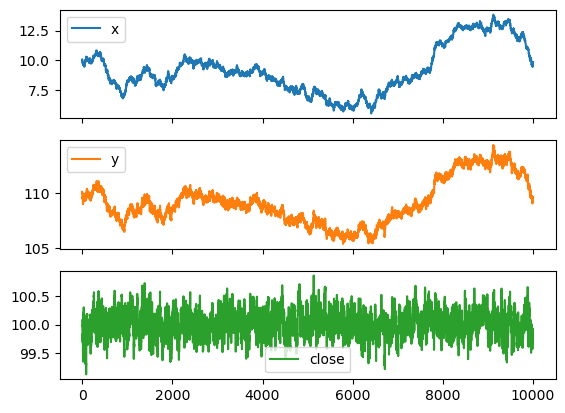

In [2]:
x, y = stationaryDGP()
spread = y - x
df = pd.DataFrame({'x': x, 'y': y, 'close': spread}) # close price of portfolio is the spread
df.plot(subplots=True)
plt.show()

In [3]:
# confirm the x, y pair is cointegrated, such that spread is stationary
x_ols = sm.add_constant(x)
ols = sm.OLS(y, x_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 8.250e+05
Date:                Tue, 04 Jun 2024   Prob (F-statistic):               0.00
Time:                        18:04:34   Log-Likelihood:                 890.61
No. Observations:               10000   AIC:                            -1777.
Df Residuals:                    9998   BIC:                            -1763.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.9867      0.010   9637.809      0.0

In [11]:
adfuller_test = adfuller(spread)
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -22.61184415461793
p-value: 0.0
Is the spread stationary? Yes


In [4]:
# build features
df_train = df.copy()

feature_config = {
    "feature_col": "close",
    "window": 7, # 7 days window, pad with first value when window is not available
    "mode": "diff" # difference between current and previous close price
}

df_train = build_rolling_feature(df_train, **feature_config)
df_train

,x,y,close,feature_rolling_0,feature_rolling_1,feature_rolling_2,feature_rolling_3,feature_rolling_4,feature_rolling_5,feature_rolling_6
0,10.058620,110.133178,100.074558,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,10.015442,110.027207,100.011764,-0.062794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,10.047642,110.051310,100.003669,-0.008095,-0.062794,0.000000,0.000000,0.000000,0.000000,0.000000
3,10.012670,109.983114,99.970444,-0.033225,-0.008095,-0.062794,0.000000,0.000000,0.000000,0.000000
4,10.032259,110.020995,99.988736,0.018292,-0.033225,-0.008095,-0.062794,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
9995,9.767448,109.661566,99.894119,0.007471,0.049885,0.166456,0.006053,-0.099561,0.014634,0.020234
9996,9.770934,109.697159,99.926225,0.032107,0.007471,0.049885,0.166456,0.006053,-0.099561,0.014634
9997,9.777435,109.553159,99.775724,-0.150502,0.032107,0.007471,0.049885,0.166456,0.006053,-0.099561
9998,9.763001,109.621151,99.858151,0.082427,-0.150502,0.032107,0.007471,0.049885,0.166456,0.006053


In [5]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0)

[ 0.  0.  0.  0.  0.  0.  0. -1. -1.]
Market Return : -0.26%   |   Portfolio Return :  0.26%   |   Position Changes : 0   |   Episode Length : 10000   |   


In [6]:
# Train a DQN agent using training data from a stationary data generating process
n_actions = env.action_space.n
n_observations = len(env.reset()[0])

agent = DQNAgent(n_observations=n_observations, n_actions=n_actions)
history_metrics, _ = agent.train(env, num_episodes=15) # Beware of overfitting when num_episodes is too high

Market Return : -0.26%   |   Portfolio Return : -41.49%   |   Position Changes : 5639   |   Episode Length : 10000   |   
Market Return : -0.26%   |   Portfolio Return : -16.92%   |   Position Changes : 4910   |   Episode Length : 10000   |   
Market Return : -0.26%   |   Portfolio Return : -0.06%   |   Position Changes : 4687   |   Episode Length : 10000   |   
Market Return : -0.26%   |   Portfolio Return :  1.84%   |   Position Changes : 4475   |   Episode Length : 10000   |   
Market Return : -0.26%   |   Portfolio Return :  8.53%   |   Position Changes : 4523   |   Episode Length : 10000   |   
Market Return : -0.26%   |   Portfolio Return :  1.62%   |   Position Changes : 4471   |   Episode Length : 10000   |   
Market Return : -0.26%   |   Portfolio Return :  5.32%   |   Position Changes : 4282   |   Episode Length : 10000   |   
Market Return : -0.26%   |   Portfolio Return : 21.11%   |   Position Changes : 4310   |   Episode Length : 10000   |   
Market Return : -0.26%   |   P

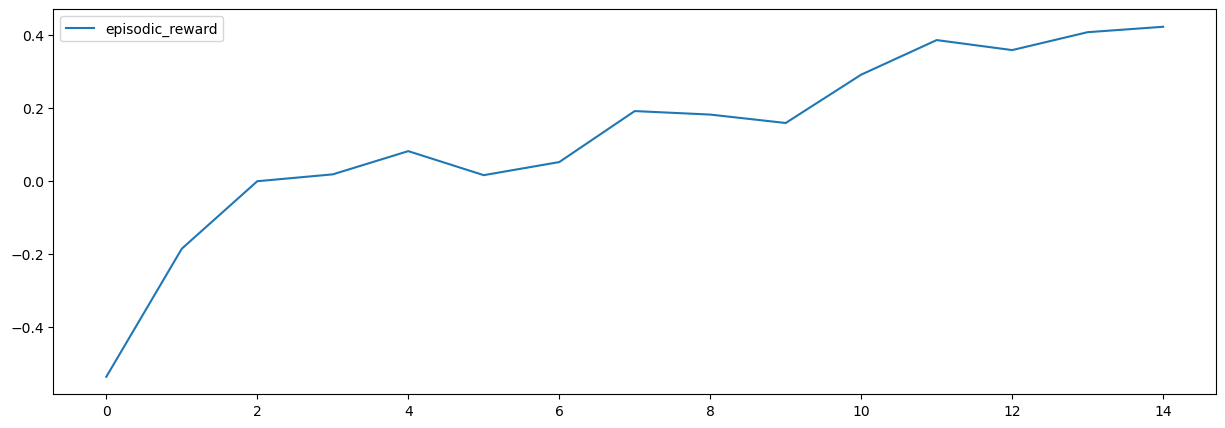

In [7]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [8]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = stationaryDGP()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    _df = build_rolling_feature(_df, **feature_config)
    
    env_test = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.34%   |   Portfolio Return : 50.14%   |   Position Changes : 2528   |   Episode Length : 10000   |   
Market Return :  0.19%   |   Portfolio Return : 32.73%   |   Position Changes : 2471   |   Episode Length : 10000   |   
Market Return :  0.48%   |   Portfolio Return : 35.57%   |   Position Changes : 2430   |   Episode Length : 10000   |   
Market Return : -0.30%   |   Portfolio Return : 43.88%   |   Position Changes : 2475   |   Episode Length : 10000   |   
Market Return :  0.31%   |   Portfolio Return : 50.57%   |   Position Changes : 2532   |   Episode Length : 10000   |   
Market Return : -0.15%   |   Portfolio Return : 57.82%   |   Position Changes : 2531   |   Episode Length : 10000   |   
Market Return :  0.28%   |   Portfolio Return : 54.06%   |   Position Changes : 2509   |   Episode Length : 10000   |   
Market Return : -0.26%   |   Portfolio Return : 51.19%   |   Position Changes : 2540   |   Episode Length : 10000   |   
Market Return : -0.07%   |   Por

In [9]:
# from gym_trading_env.renderer import Renderer
# renderer = Renderer(render_logs_dir="render_logs")
# renderer.run()